<a href="https://colab.research.google.com/github/PauloGunther/project_pos/blob/main/tcc_etl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Preparação e manipulação
O objetivo é combinar o dataset com preços dos imóveis (R$/m²) proveniente da FIPEZAP, com as váriaveis macroeconomicas do Banco Central - SGS



In [ ]:
# Carregar bibliotecas

!pip install python-bcb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bcb import sgs # API dados abertos Banco Central
from sklearn.preprocessing import StandardScaler # Padronizar variaveis
import statsmodels.api as sm

# Avaliar multicolinearidade
from statsmodels.stats.outliers_influence import variance_inflation_factor


pd.set_option('display.max_columns', None)


## 1.1 Coleta de dados

### Dados da FIPEZAP
Fonte dos dados: FIPEZAP

Por meio do excel, foi realizado uma seleção das variaveis de interesse, focando nos dados gerais do Brasil e em Goiania, que é o objeto de estudo.

Todos os dados sao referentes a imóveis resindências. As features deste dataset são:

* date - mês, iniciando em jan/2014.

* br_rent - preço de aluguel médio do Brasil - R$/m²

* go_price - preço de venda  Goiania - R$/m²

* go_rent - preço de aluguel Goiania - R$/m²


In [ ]:
# Importar dataset da fipezap com preços de imóveis

url = "https://github.com/PauloGunther/project_pos/raw/refs/heads/main/fipezap.xlsx"

df_fipe = pd.read_excel(url, engine='openpyxl')
df_fipe.tail()

,date,br_price,br_rent,go_price,go_rent
133,2025-02-01,9134.0,47.5,7974.0,40.7
134,2025-03-01,9188.0,48.1,7982.0,40.9
135,2025-04-01,9235.0,48.7,7936.0,41.1
136,2025-05-01,9278.0,49.0,7905.0,41.2
137,2025-06-01,9319.0,49.2,7886.0,41.8


### Dados do Banco Central
Através da biblioteca do SGS, do banco central, foi importado as variaveis X do estudo.
Variáveis imporadas do SGS. Cada uma destas variaveis tem um código específico no SGS.

#### 1) dolar - Câmbio
Média mensal de compra do dolar em R$. Este indicador pode impactar em custos de materiais, mesmo em insumos nacionais como aço, pois tem preços cotados no mercao internacional. Além disso, varias componetes de acabaamento são importados, como: elevadores, revestimento, climatização.

#### 2) selic - Taxa selic
Valor acumulado anual.. Influencia diretamente o custo do crédito, inflação e crescimento econômico.

#### 3) tx_juros - 	Taxa média de juros das operações de crédito
Influencia diretamente o custo do crédito, inflação e crescimento econômico. Valor em porcentagem acumulada dos últimos 12 meses.

#### 4) ipca - Índice nacional de preços ao consumidor-amplo
Fortemente ligada a Selic, porém pode ser afetada por risco de inadimplência e concorrência do mercado. Valor em porcentagem acumulada dos últimos 12 meses.

#### 5) renda_med - Rendimento médio real habitual das pessoas ocupadas
Rendimento de pessoas empregadas descontando a inflação. . Valor mensal em Real.

#### 6) desocupado - 	Pessoas desocupadas - PNADC
Contingente de indivíduos em idade de trabalhar que, durante a pesquisa não tinham disponibilidade para trabalhar, mas não estavam ocupadas e ativamente estavam procurando ocupação. Valor em milhares de pessoas.

#### 7) ocupado_rend - População ocupada com rendimento
Indivíduos com 14 anos ou mais que trabalharam pelo menos 1 hora na semana de referência em atividade remunerada (formal ou informal). Valor em milhares de pessoas.


#### 8) incc - Indice de custo de construção geral (Mão de obra + Material)
Este indicador mede a variação dos custos de construção civil residencial no Brasil, calculado mensalmente pela FGV. Foca em habitação populares e médias. Abrange matérias e mão de obra. Valor em porcentagem de variação mensal.

#### 9) ic_agro - Indice de preços de commodities focado apenas em agricolas
É um índice que acompanha exclusivamente a variação de preços das principais commodities agrícolas negociadas no mercado, como soja, milho e outros grãos.

#### 10) inadimplencia - Inadimplência das operações de crédito - GO - Total
Porcentagem de empréstimos e financiamentos com atraso superior a 90 dias em relação ao total de crédito concedido.

#### 11) sald_cred_pf - Saldo da carteira de crédito imobiliario - PF
Valor em R$ milhões. É o valor total que ainda está em aberto, ou seja, ainda não foi quitado pelos tomadores de crédito imobiliário em uma determinada data. Nesta variavel, apenas para pessoas físicas.

#### 12) sald_cred_pj - Saldo da carteira de crédito imobiliario - PF
Valor em R$ milhões. É o valor total que ainda está em aberto, ou seja, ainda não foi quitado pelos tomadores de crédito imobiliário em uma determinada data.
Nesta variavel, apenas para pessoas juríca.

#### 13) vol_cred_pj - Concessões de crédito imobiliario - PJ
É o total de novos financiamentos concedidos em um determinado período apenas para pessoas jurídicas. Valor dado em R$ milhões

#### 14) vol_cred_pf - Concessões de crédito imobiliario - PJ
É o total de novos financiamentos concedidos em um determinado período apenas para pessoas físicas. Valor dado em R$ milhões

#### 15) Inadimplência imobiliária Pessoa Jurídica [PJ]
Refere-se ao atraso no pagamento de financiamentos, leasing imobiliário ou contratos de construção por empresas.


#### 16) Inadimplência imobiliária Pessoa Física [PF]
Reflete a saúde do mercado imobiliário e a capacidade de pagamento das famílias, medindo o percentual de financiamentos de imóveis residenciais com pagamentos em atraso por mais de 90 dias.


In [ ]:
# Definir códigos indicadores

indicadores = {
    'dolar': 3697,          # R$/USD
    'selic': 4189,          # %a.a. acumulado
    'tx_juros': 20714,      # %a.a. acumulado
    'ipca': 433,            # var %a.m
    'renda_med': 24382,     # R$
    'desocupado': 24380,    # mil pessoas
    'ocupado_rend': 28543,  # mil pessoas
    'incc': 192,            # var %a.m
    'ic_agro': 27575,       # índice
    'inadim_go': 15933,     # %
    'inadim_imob_pf': 21151,   # %
    'inadim_imob_pj': 21139,   # %
    'sald_cred_pf': 20612, # R$ milhões
    'sald_cred_pj': 20600,  # R$ milhões
    'vol_cred_pj': 20692,   # R$ milhões
    'vol_cred_pf': 20704   # R$ milhões
}


# Coletar dados do SGS
df_indicadores = sgs.get(indicadores, start= '2013-01-01')

In [ ]:
df_indicadores.tail()

,dolar,selic,tx_juros,ipca,renda_med,desocupado,ocupado_rend,incc,ic_agro,inadim_go,inadim_imob_pf,inadim_imob_pj,sald_cred_pf,sald_cred_pj,vol_cred_pj,vol_cred_pf
Date,,,,,,,,,,,,,,,,
2025-04-01,5.7831,14.15,31.53,0.43,3331.0,7130.0,99972.0,0.52,494.59,4.40,1.25,0.94,1211232.0,65134.0,3196.0,18617.0
2025-05-01,5.6668,14.55,31.56,0.26,3342.0,6690.0,100585.0,0.58,491.25,4.50,1.25,1.08,1223264.0,66648.0,3441.0,18538.0
2025-06-01,5.5465,14.74,31.52,0.24,3369.0,6253.0,101004.0,0.69,476.21,4.33,1.13,0.96,1232975.0,67467.0,3447.0,18426.0
2025-07-01,5.5279,14.90,NaN,0.26,NaN,NaN,NaN,0.91,470.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-08-01,NaN,14.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1.2 Limpeza e Pré processamento

In [ ]:
# Copiar dataset das variaveis macroeconomicas para manipula-lo
df_indic = df_indicadores.copy()

# Transformar var %am em acumulado no ano (ipca e incc)
df_indic['ipca_fator'] = 1 + (df_indic['ipca'] / 100)
df_indic['incc_fator'] = 1 + (df_indic['incc'] / 100)


# Acumulado dos últimos 12 meses (rolar)
df_indic['ipca'] = (
    df_indic['ipca_fator']
    .rolling(window=12)
    .apply(lambda x: x.prod() - 1, raw=True)* 100)

df_indic['incc'] = (
    df_indic['incc_fator']
    .rolling(window=12)
    .apply(lambda x: x.prod() - 1, raw=True)* 100)

# Eliminar colunas de apoio
df_indic = df_indic.drop(columns=['ipca_fator', 'incc_fator'])

In [ ]:
# Tranformar index de data em feature
df_indic = df_indic.reset_index()
df_indic = df_indic.rename(columns={'Date': 'date'})

In [ ]:
# Filtar para iniciar no mesmo mês do primeiro registro do df_fipe
df_indic = df_indic[df_indic['date'] >= '2014-01-01']

In [ ]:
# Combinar os dois dataframes
df_inicial = pd.merge(df_fipe, df_indic, on='date')

In [ ]:
df_inicial.tail()

,date,br_price,br_rent,go_price,go_rent,dolar,selic,tx_juros,ipca,renda_med,desocupado,ocupado_rend,incc,ic_agro,inadim_go,inadim_imob_pf,inadim_imob_pj,sald_cred_pf,sald_cred_pj,vol_cred_pj,vol_cred_pf
133,2025-02-01,9134.0,47.5,7974.0,40.7,5.7650,13.15,30.56,5.057630,3335.0,7328.0,99291.0,7.419134,510.22,4.16,1.18,0.51,1188085.0,62634.0,2606.0,17928.0
134,2025-03-01,9188.0,48.1,7982.0,40.9,5.7462,13.57,31.25,5.477190,3347.0,7566.0,99213.0,7.536965,484.87,4.13,1.23,0.76,1199798.0,63879.0,2754.0,17490.0
135,2025-04-01,9235.0,48.7,7936.0,41.1,5.7831,14.15,31.53,5.529729,3331.0,7130.0,99972.0,7.536965,494.59,4.40,1.25,0.94,1211232.0,65134.0,3196.0,18617.0
136,2025-05-01,9278.0,49.0,7905.0,41.2,5.6668,14.55,31.56,5.319636,3342.0,6690.0,100585.0,7.238429,491.25,4.50,1.25,1.08,1223264.0,66648.0,3441.0,18538.0
137,2025-06-01,9319.0,49.2,7886.0,41.8,5.5465,14.74,31.52,5.351165,3369.0,6253.0,101004.0,7.217132,476.21,4.33,1.13,0.96,1232975.0,67467.0,3447.0,18426.0


# 2. EDA


## 2.1 Análise geral
A partir de 2021 o preço do metro quadrado dos imóveis residenciais em Goiânia passou a apresentar um crescimento acima da média nacional. Apesar disso, os valores praticados na capital goiana ainda permanecem inferiores aos observados nos principais centros urbanos do país.

Nota-se que a partir de janeiro de 2020 houve um crescimento mais acentuado em Goiana em relação ao Brasil. No entanto, a partir de meados de 2024 há uma tendência de queda no preço do metro quadrado em Goiana, já o preço nacional segue o movimento de alta.



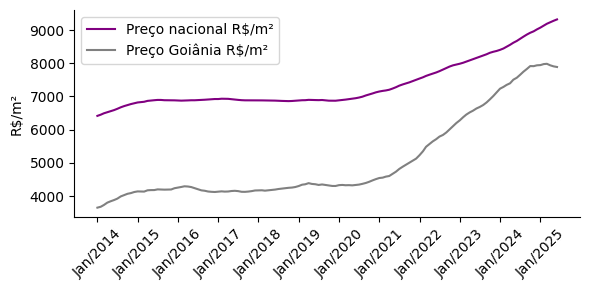

In [ ]:
# Tamanho da figura
plt.figure(figsize=(6, 3))

# Plot da primeira série
plt.plot(df_inicial['date'], df_inicial['br_price'], label='Preço nacional R$/m²',color ='purple')

# Plot da segunda série
plt.plot(df_inicial['date'], df_inicial['go_price'], label='Preço Goiânia R$/m²', color ='grey')

# Opções dos eixos
plt.ylabel('R$/m²', fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(df_inicial['date'][::12], df_inicial['date'][::12].dt.strftime('%b/%Y'), rotation=45, fontsize=10)

# Legedas
plt.legend()

# Tirar eixos paralelos
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustar gráfico
plt.tight_layout()
plt.show()


## 2.2 Rentabilidade imobiliaria
Para analisar o imóvel como um ativo de investimento, foi criada uma variável que é resultado da soma do retorno bruto do aluguel com a valorização do imóvel. Em nível nacional, o rendimento total dos imóveis superou a taxa Selic — utilizada como benchmark — caracterizando-se como um investimento atrativo ao longo do último ano

Em Goiânia, o retorno total dos investimentos imobiliários esteve acima da média nacional desde 2021, chegando a atingir taxas de até 25% ao ano em 2022.

No entanto, a valorização dos imóveis na capital goiana tem se mantido próxima de 0% nos últimos meses, o que reduziu o retorno anualizado. Esse comportamento trouxe o rendimento dos imóveis para próximo da média nacional, aproximando o desempenho dos investimentos imobiliários locais à taxa Selic.

In [ ]:
# Calcular rentabilidade nacional
var_price_br = 100*df_inicial['br_price'].pct_change() # Variação do preço do imóvel
var_rent_br = 100*df_inicial['br_rent']/df_inicial['br_price'] # Rentabilidade bruta aluguel

yield_total_br = var_price_br + var_rent_br # Rendimento total nacional

# Tornando rendimento acumulado no ano para comparar com selic
yield_fator = 1 + (yield_total_br / 100)

yield_nac = (
    yield_fator
    .rolling(window=12)
    .apply(lambda x: x.prod() - 1, raw=True)* 100)  # Rendimento %a.a.

In [ ]:
# Calcular rentabilidade goiania
var_price_go = 100*df_inicial['go_price'].pct_change() # Variação do preço do imóvel
var_rent_go = 100*df_inicial['go_rent']/df_inicial['go_price'] # Rentabilidade bruta aluguel

yield_total_go = var_price_go + var_rent_go # Rendimento do imovel goiania

# Tornando rendimento acumulado no ano para comparar com selic
yield_fator = 1 + (yield_total_go / 100)

yield_go = (
    yield_fator
    .rolling(window=12)
    .apply(lambda x: x.prod() - 1, raw=True)* 100)  # Rendimento %a.a.

In [ ]:
 # Taxa selic
selic = df_inicial['selic'] #%a.a.

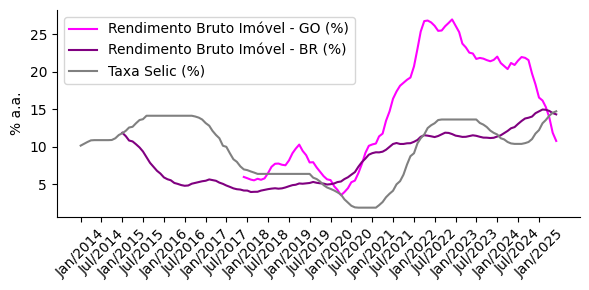

In [ ]:
# Plot do gráfico
plt.figure(figsize=(6, 3))

# Plot séries
plt.plot(df_inicial['date'],
         yield_go, label='Rendimento Bruto Imóvel - GO (%)',
         color='magenta')
plt.plot(df_inicial['date'],
         yield_nac,
         label='Rendimento Bruto Imóvel - BR (%)',
         color='purple')
plt.plot(df_inicial['date'],
         selic, label='Taxa Selic (%)',
         color='gray')

# Configuração de eixo
plt.ylabel('% a.a.', fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(df_inicial['date'][::6], df_inicial['date'][::6].dt.strftime('%b/%Y'), rotation=45, fontsize=10)

# Legenda
plt.legend()

# Eliinar eixos paralelos
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.tight_layout()
plt.show()

## 2.3 Correlações iniciais
As maiores correlações com o preço do metro quadrado dos imóveis de Goiânia foram encontradas no:

* saldo de crédito imobiliária de pessoa física
* índice de commodities agrícolas
* rendimento médio das pessoas ocupadas
* volume de crédito pessoa física.

Essas 4 variáveis mostraram correlação direta e com valores maiores que 0,80

In [ ]:
# variaveis para exluir do df, matendo apenas a variavel dependente
excluir = ['br_price',
           'br_rent',
           'go_rent',
           'date']

# df para fazer correlação
df_corr = df_inicial.drop(columns=excluir).dropna()

/tmp/ipython-input-2544691846.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


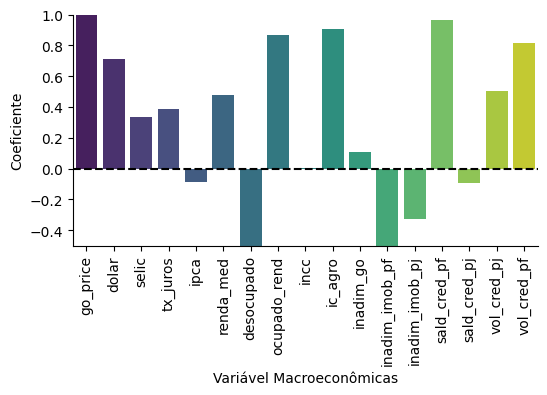

In [ ]:
# Calcular correlações
correl = df_corr.corr()

# Plotar
plt.figure(figsize=(6, 3))
sns.barplot(
    x=correl.index,
    y=correl['go_price'],
    palette='viridis'
)

# Configuração de eixos
plt.ylabel('Coeficiente', fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(-0.5, 1)  # Limite do eixo Y
plt.xlabel('Variável Macroeconômicas', fontsize=10)
plt.xticks(fontsize=10, rotation=90)
plt.axhline(0, color='black', linestyle='--')  # Linha de referência

# Remover eixos opostos
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

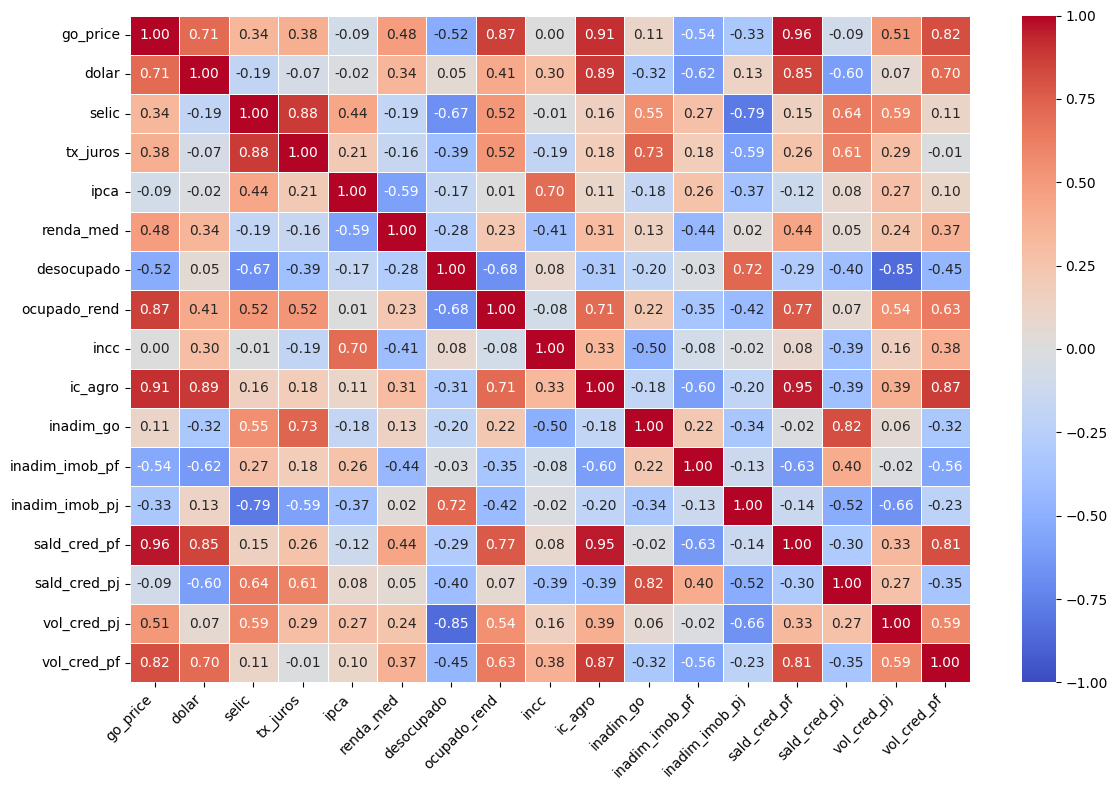

In [ ]:
# Plotar matriz de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(correl,
            annot=True,        # Mostrar valores nas células
            fmt=".2f",         # Formato com 2 decimais
            cmap='coolwarm',   # Mapa de cores
            vmin=-1, vmax=1,   # Limites para a escala de cores
            linewidths=0.5,    # Largura das linhas entre células
            cbar=True)         # Mostrar barra de cores

# Configuração de eixo
plt.xticks(rotation=45, ha='right')

plt.tight_layout()  # Ajustar layout
plt.show()

## 2.4 Engenharia de features
Na etapa de engenharia de variáveis (feature engineering), foram analisadas as 16 variáveis macroeconômicas com base em sua relevância.

### 2.4.1 PF e PJ
Os volumes e saldos de crédito imobiliário para pessoas físicas [PF] e jurídicas [PJ] foram somados para gerar variáveis agregadas de volume e saldo total. Essa estratégia foi adotada devido à baixa representatividade dos valores referentes a pessoas jurídicas em comparação aos de pessoas físicas. Como resultado, as variáveis combinadas apresentaram correlação mais elevada com o preço dos imóveis.

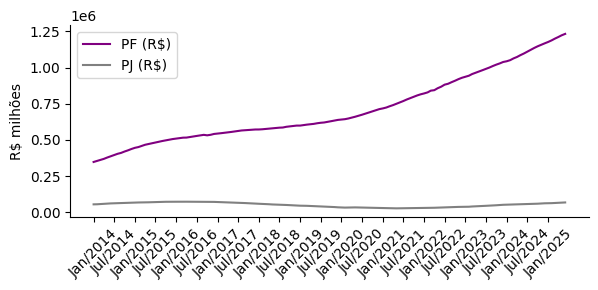

In [ ]:
# Plotar grafico
plt.figure(figsize=(6, 3))

# Plot do saldo PF
plt.plot(df_inicial['date'],
         df_inicial['sald_cred_pf'],
         label='PF (R$)',
         color='purple')

# Plot do saldo PJ
plt.plot(df_inicial['date'],
         df_inicial['sald_cred_pj'],
         label='PJ (R$)',
         color='gray')

# Configurção de eixo
plt.ylabel('R$ milhões', fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(df_inicial['date'][::6],
           df_inicial['date'][::6].dt.strftime('%b/%Y'),
           rotation=45,
           fontsize=10) # Parametros eixo X

# Legenda
plt.legend()

# Excluir eixos paralelos
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

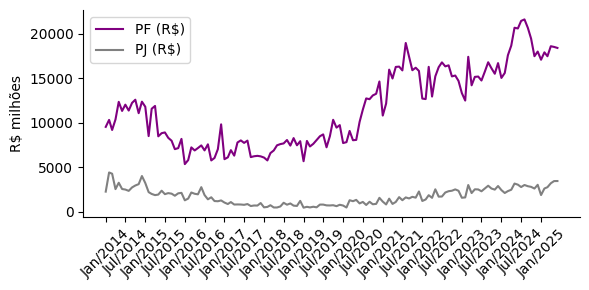

In [ ]:
# Plotar grafico
plt.figure(figsize=(6, 3))

# Plot volume de credito PF
plt.plot(df_inicial['date'],
         df_inicial['vol_cred_pf'],
         label='PF (R$)',
         color='purple')

# Plot volume de credito PJ
plt.plot(df_inicial['date'],
         df_inicial['vol_cred_pj'],
         label='PJ (R$)',
         color='gray')

# Configurção de eixo
plt.ylabel('R$ milhões', fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(df_inicial['date'][::6],
           df_inicial['date'][::6].dt.strftime('%b/%Y'),
           rotation=45,
           fontsize=10)

# Legenda
plt.legend()

# Excluir eixos paralelos
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
# Agrupando váriaveis PF e PJ
df_corr['vol_cred'] = df_corr['vol_cred_pf'] + df_corr['vol_cred_pj']
df_corr['sald_cred'] = df_corr['sald_cred_pf'] + df_corr['sald_cred_pj']

# Eliminando variaveis iniciais PF e PJ
df_corr1 = df_corr.drop(columns=['vol_cred_pf',
                                  'vol_cred_pj',
                                  'sald_cred_pf',
                                  'sald_cred_pj'])

### 2.4.2 Taxa de Juros e SELIC
Devido à alta correlação entre a taxa de juros das operações de crédito e a taxa Selic, optou-se por excluir a taxa Selic do modelo, com o objetivo de evitar problemas de multicolinearidade, mantendo a variável que demonstrou maior correlação com a variável dependente.

In [ ]:
df_corr1 = df_corr1.drop(columns=['selic'])

### 2.4.3 Desocupados e ocupados com renda

Embora as variáveis número de desocupados e ocupados com renda não apresentem multicolinearidade estatística, a análise gráfica revelou um comportamento inverso entre elas, com uma defasagem temporal (lag) estimado entre 3 e 6 meses. Por esse motivo, optou-se por excluir a variável "desocupados", por apresentar menor correlação com o preço.

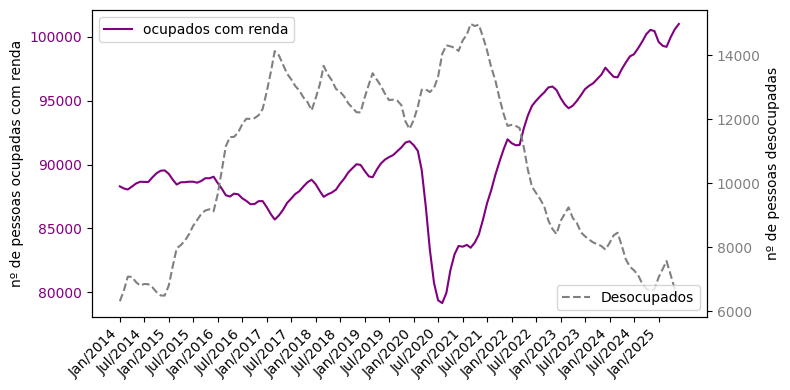

In [ ]:
# Cria figura e eixo principal
fig, ax1 = plt.subplots(figsize=(8, 4))

# Séries
y1 = df_inicial['desocupado']
y2 = df_inicial['ocupado_rend']

# Configurações primeiro Y
ax1.plot(df_inicial['date'], y2, color="purple", alpha=1, label="ocupados com renda")
ax1.set_ylabel("nº de pessoas ocupadas com renda", fontsize=10)
ax1.tick_params(axis="y", labelcolor="purple")
plt.legend(loc="upper left")

# Cria um segundo eixo Y
ax2 = ax1.twinx()

# Configurações segundo Y
ax2.plot(df_inicial['date'], y1, color="gray", alpha=1, linestyle='dashed', label="Desocupados")
ax2.set_ylabel("nº de pessoas desocupadas", fontsize=10)
ax2.tick_params(axis="y", labelcolor="gray")

# Configurações eixo X
fig.autofmt_xdate(rotation=45)
plt.xticks(df_inicial['date'][::6], df_inicial['date'][::6].dt.strftime('%b/%Y'), fontsize=10)

# Legendas
plt.legend(loc="lower right", fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# Eliminando feature com o número de desocupados
df_corr1 = df_corr1.drop(columns='desocupado')

### 2.4.4 Indimplencias
Três variáveis relacionadas à inadimplência foram avaliadas: duas referentes à inadimplência imobiliária de pessoas físicas e jurídicas, e uma à inadimplência geral no estado de Goiás. As duas primeiras foram ponderadas pelos respectivos saldos de crédito imobiliário e agregadas em uma única variável.

Já a inadimplência geral em Goiás foi excluída da análise por não apresentar correlação relevante.


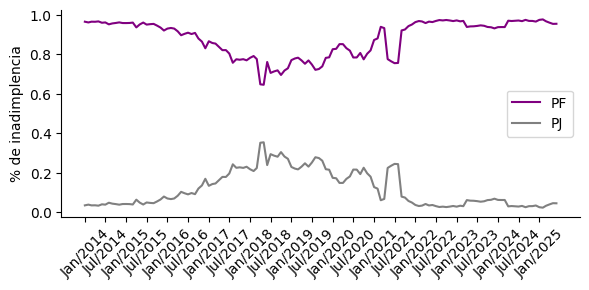

In [ ]:
# Criando variaveis para verificar proporção de cada uma no saldo de crédito
y_pf = df_inicial['inadim_imob_pf']*df_inicial['sald_cred_pf']/100
y_pj = df_inicial['inadim_imob_pj']*df_inicial['sald_cred_pj']/100
prop_pf = y_pf/(y_pf + y_pj)
prop_pj = y_pj/(y_pf + y_pj)

# Plot do gráfico
plt.figure(figsize=(6, 3))

# Plot séries
plt.plot(df_inicial['date'],
         prop_pf,
         label='PF',
         color='purple')
plt.plot(df_inicial['date'],
         prop_pj,
         label='PJ',
         color='gray')

# Configuração de eixo
plt.ylabel('% de inadimplencia', fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(df_inicial['date'][::6], df_inicial['date'][::6].dt.strftime('%b/%Y'), rotation=45, fontsize=10)

# Legenda
plt.legend()

# Eliminar eixos paralelos
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.tight_layout()
plt.show()

In [ ]:
# Agrupando as duas variaveis de inadimplecia pelos saldos de crédito
inadim_imob = 100*(y_pj + y_pf) / (df_inicial['sald_cred_pf'] + df_inicial['sald_cred_pj'])

# Adicionando nova variavel no DF correlção
df_corr1['inadim_imob'] = inadim_imob

In [ ]:
# Selecionando as variaveis
inadimplencias = ['inadim_imob', 'inadim_imob_pf', 'inadim_imob_pj', 'inadim_go']
preco = 'go_price'

# Calcular correlacao das inadimplencias
correlacoes = df_corr1[[preco] + inadimplencias].corr()[preco]

# Tirar correlação com ela mesma
correlacoes = correlacoes.drop(preco)

print(correlacoes)

inadim_imob      -0.639617
inadim_imob_pf   -0.535314
inadim_imob_pj   -0.327540
inadim_go         0.110458
Name: go_price, dtype: float64


In [ ]:
# Eliminando
df_corr1 = df_corr1.drop(columns=['inadim_imob_pf', 'inadim_imob_pj', 'inadim_go'])

### 2.4.5 IC_AGRO e DOLAR

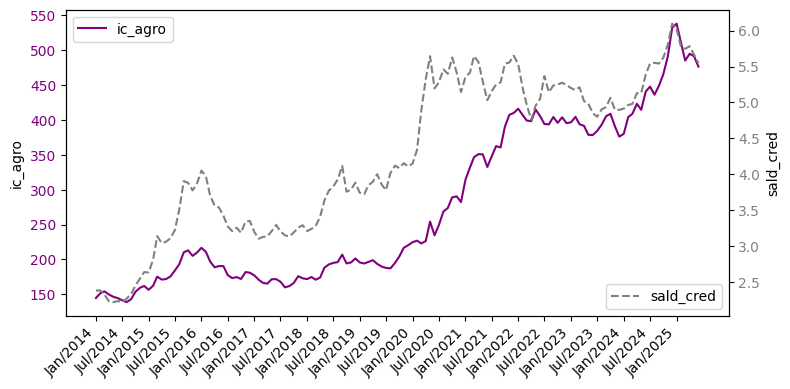

In [ ]:
# Cria figura e eixo principal
fig, ax1 = plt.subplots(figsize=(8, 4))

# Séries
y1 = df_corr1["dolar"]
y2 = df_corr1["ic_agro"]

# Configurações primeiro Y
ax1.plot(df_inicial['date'], y2, color="purple", alpha=1, label="ic_agro")
ax1.set_ylabel("ic_agro", fontsize=10)
ax1.tick_params(axis="y", labelcolor="purple")
plt.legend(loc="upper left")

# Cria um segundo eixo Y
ax2 = ax1.twinx()

# Configurações segundo Y
ax2.plot(df_inicial['date'], y1, color="gray", alpha=1, linestyle='dashed', label="sald_cred")
ax2.set_ylabel("sald_cred", fontsize=10)
ax2.tick_params(axis="y", labelcolor="gray")

# Configurações eixo X
fig.autofmt_xdate(rotation=45)
plt.xticks(df_inicial['date'][::6], df_inicial['date'][::6].dt.strftime('%b/%Y'), fontsize=10)

# Legendas
plt.legend(loc="lower right", fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# Eliminando
df_corr1 = df_corr1.drop(columns=['dolar'])

## 2.5 Novas correlações

/tmp/ipython-input-334421131.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


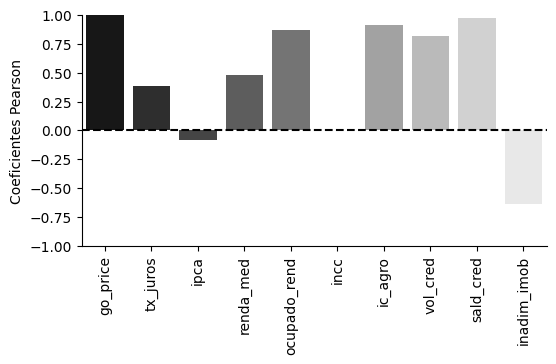

In [ ]:
# Calcular correlações com as novas variaveis
corr2 = df_corr1.corr()

# Plotar
plt.figure(figsize=(6, 3))
sns.barplot(
    x=corr2.index,
    y=corr2['go_price'],
    palette='gray'
)

# Linha de referência
plt.axhline(0, color='black', linestyle='--')

# Confirguração de eixos
plt.ylabel('Coeficientes Pearson', fontsize=10)
plt.xticks(fontsize=10)
plt.ylim(-1, 1)
plt.xticks(rotation=90, fontsize=10)
plt.xlabel("")

# Eliminar eixos paralelos
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

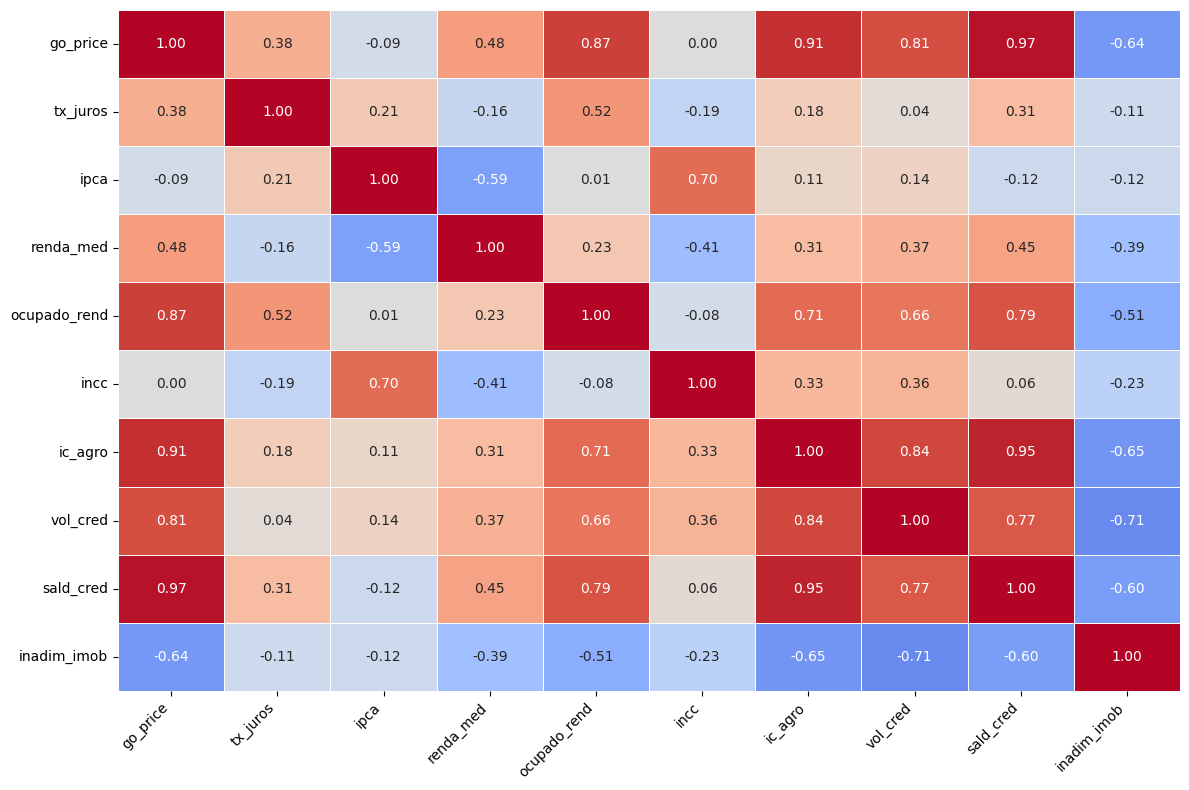

In [ ]:
# Plotar matriz de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(corr2,
            annot=True,        # Mostrar valores nas células
            fmt=".2f",         # Formato com 2 decimais
            cmap='coolwarm',   # Mapa de cores
            vmin=-1, vmax=1,   # Limites para a escala de cores
            linewidths=0.5,    # Largura das linhas entre células
            cbar=False)        # Mostrar barra de cores

# Ajustar eixos
plt.xticks(rotation=45, ha='right')  # Rotacionar rótulos do eixo x
plt.tight_layout()  # Ajustar layout

plt.show()

In [ ]:
# DF para calculo do VIF
df_vif = df_corr1.drop(columns=['go_price'])

# Adicionar constante
X_const = sm.add_constant(df_vif)

# Calcular VIF
vif = pd.DataFrame()
vif["Variável"] = X_const.columns
vif["VIF"] = [variance_inflation_factor(X_const.values, i)
              for i in range(X_const.shape[1])]

print(vif)

       Variável          VIF
0         const  5957.266429
1      tx_juros     3.251783
2          ipca     4.482907
3     renda_med     3.418646
4  ocupado_rend     5.000923
5          incc     5.653854
6       ic_agro    51.478831
7      vol_cred     5.955839
8     sald_cred    55.584870
9   inadim_imob     2.345048


# 2.6 Dataframe final

In [ ]:
# Variaviel a exlcuir do dataframe inicial
excluir = ['br_price',
           'br_rent',
           'go_rent',
           'selic',
           'desocupado',
           'inadim_go',
           'dolar']

#Exclusão
df_inicial = df_inicial.drop(columns=excluir)

In [ ]:
# Agregar indimplencias

# Obter numero absoluto de indimplencia em R$
pf = df_inicial['inadim_imob_pf']*df_inicial['sald_cred_pf']
pj = df_inicial['inadim_imob_pj']*df_inicial['sald_cred_pj']

# Retornar a inadimplecia para porcentagem, agregando PJ e PF
inadim_imob = (pf + pj) / (df_inicial['sald_cred_pf'] + df_inicial['sald_cred_pj'])

# Adicionar nova variavel ao DF
df_inicial['inadim_imob'] = inadim_imob

# Eliminar variaveis iniciais de inadimplecia pj e pf
df_inicial = df_inicial.drop(columns=['inadim_imob_pj',
                                  'inadim_imob_pf'])



In [ ]:
# Agrupar váriaveis  de volume e soldo de credito PF e PJ
df_inicial['vol_cred'] = df_inicial['vol_cred_pf'] + df_inicial['vol_cred_pj']
df_inicial['sald_cred'] = df_inicial['sald_cred_pf'] + df_inicial['sald_cred_pj']

# Eliminar variaveis iniciais PF e PJ
df_inicial = df_inicial.drop(columns=['vol_cred_pf',
                                  'vol_cred_pj',
                                  'sald_cred_pf',
                                  'sald_cred_pj'])

In [ ]:
# Salvar df pre processado
df_inicial.to_pickle("df_pre_model.pkl")
df_inicial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          138 non-null    datetime64[ns]
 1   go_price      138 non-null    float64       
 2   tx_juros      138 non-null    float64       
 3   ipca          138 non-null    float64       
 4   renda_med     138 non-null    float64       
 5   ocupado_rend  138 non-null    float64       
 6   incc          138 non-null    float64       
 7   ic_agro       138 non-null    float64       
 8   inadim_imob   138 non-null    float64       
 9   vol_cred      138 non-null    float64       
 10  sald_cred     138 non-null    float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 12.0 KB
